In [1]:
import sys

sys.path.append(".")

import os
import random
import pickle
import numpy as np
import pandas as pd
import ipywidgets as widgets
from typing import List, Tuple, Dict
from IPython.display import display
from pathlib import Path
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from pyimzml.ImzMLParser import ImzMLParser
from pyimzml.ImzMLWriter import ImzMLWriter
from scipy.cluster.hierarchy import dendrogram, fcluster
from skimage.filters import gaussian
from sklearn.cluster import AgglomerativeClustering
from processing import aligned_representation, common_representation, ZScoreCorrection
from utils import read_msi

In [2]:
# Define folder that contains data
BASE_PATH = Path("./../") / "data" / "LIVER"
#BASE_PATH = Path("./../") / "data" / "CHIP_TYPES_NEW"
#BASE_PATH = Path("./../") / "data" / "DHG"
# Define folder that contains raw data
RAW_DATA = BASE_PATH / "raw"
# Define folder to save aligned data
ALIGNED_DATA = BASE_PATH / "aligned"
ALIGNED_DATA.mkdir(parents=True, exist_ok=True)
# Define folder to save processed data
PROCESSED_DATA = BASE_PATH / "processed"
PROCESSED_DATA.mkdir(parents=True, exist_ok=True)
# Define file that contains metadata
METADATA_PATH = BASE_PATH / "metadata.csv"
# Define mass range start value
MZ_START = 50
# Define mass range end value
MZ_END = 1200
# Define mass resolution of the data
MASS_RESOLUTION = 0.025
# Define lock mass reference peak
LOCK_MASS_PEAK = 885.5498
# Define lock mass tol
LOCK_MASK_TOL = 0.3
# Define mz where lipid start
MZ_LIPID_START = 600
# Define mz where lipid end
MZ_LIPID_END = 900
# Define sigma for Gaussian smoothing
GAUSSIAN_SIGMA = 2
# Define number of clusters for background-tissue hierarchical clustering
NUM_OF_CLUSTERS = 10
# Define random seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [3]:
# Read metadata csv
metadata_df = pd.read_csv(METADATA_PATH)
metadata_df["sample_number"] = metadata_df.sample_file_name.apply(
    lambda s: s.split("_")[0]
)

In [ ]:
# Loop over each unique msi imzML file
for file_name in tqdm(metadata_df.file_name.unique()):
  # Define path to msi imzML file
  msi_path = RAW_DATA / f"{file_name}.imzML"
  # Define path to new msi imzML file after alignment
  output_path = ALIGNED_DATA / f"{file_name}.imzML"
  # Align MSI
  aligned_representation(msi_path, output_path, LOCK_MASS_PEAK, LOCK_MASK_TOL)

In [ ]:
# Loop over each ROI in data frame
for _, roi in tqdm(metadata_df.iterrows(), total=metadata_df.shape[0]):
  # Define path to msi imzML file
  msi_path = os.path.join(ALIGNED_DATA, f"{roi.file_name}.imzML")
  # Define path to new msi imzML file after processing
  output_path = os.path.join(PROCESSED_DATA, f"{roi.sample_file_name}")
  # Create output folder if doesn't exist
  Path(output_path).mkdir(parents=True, exist_ok=True)
  # Create common representation
  common_representation(
      msi_path, output_path, roi.x_min, roi.x_max, roi.y_min, roi.y_max,
      MZ_START, MZ_END, MASS_RESOLUTION / 2
  )

In [ ]:
def plot_dendrogram(model: AgglomerativeClustering, **kwargs: Dict) -> np.array:
  """Plot a dendrogram and return the cluster labels based on the given 
      hierarchical clustering model.

  Args:
    model (AgglomerativeClustering): The hierarchical clustering model object.
    **kwargs (Dict): Additional keyword arguments to pass to the `dendrogram` 
        function from `scipy.cluster.hierarchy`.
  
  Returns:
    np.array: Array of cluster labels where each element corresponds to the
        cluster index of the respective sample.
  
  """

  # Initialize count array for internal nodes
  counts = np.zeros(model.children_.shape[0])
  # Number of initial samples
  n_samples = len(model.labels_)
  # Create the counts of samples under each node in the hierarchical tree
  for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
      if child_idx < n_samples:
        # Directly add leaf node
        current_count += 1
      else:
        # Add count from previously merged node
        current_count += counts[child_idx - n_samples]
    # Store count of samples under the node
    counts[i] = current_count
  # Create the linkage matrix required by the dendrogram function
  linkage_matrix = np.column_stack([model.children_, model.distances_,
                                    counts]).astype(float)

  # Extract labels if 'p' is specified in kwargs, using 'maxclust' criterion
  labels = fcluster(linkage_matrix, kwargs.get('p', 2), criterion='maxclust')

  # Plot the corresponding dendrogram
  dendrogram(linkage_matrix, **kwargs)
  plt.show()

  return labels

In [ ]:
# Create empty list to store files
files = []
# Loop over processed data dir
for folder in PROCESSED_DATA.iterdir():
  # Loop over files in each sub folder
  for file in folder.iterdir():
    # Check if common_representation file
    if 'common_representation.imzML' == file.name:
      # Add to list
      files.append(file)
# Print files to enable selection in next cell
files

[PosixPath('../data/LIVER/processed/liver_opt_1/common_representation.imzML'),
 PosixPath('../data/LIVER/processed/liver_opt_2/common_representation.imzML'),
 PosixPath('../data/LIVER/processed/liver_opt_3/common_representation.imzML'),
 PosixPath('../data/LIVER/processed/liver_std_1/common_representation.imzML'),
 PosixPath('../data/LIVER/processed/liver_std_2/common_representation.imzML'),
 PosixPath('../data/LIVER/processed/liver_std_3/common_representation.imzML')]

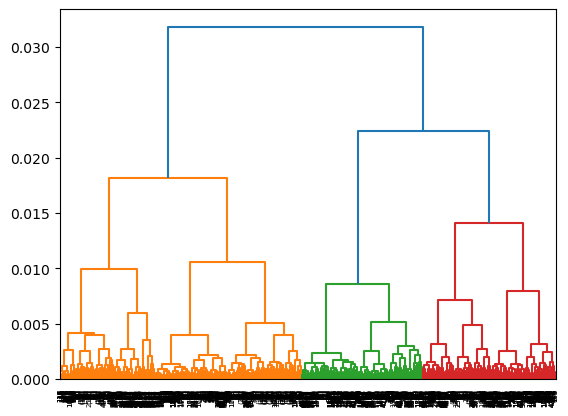

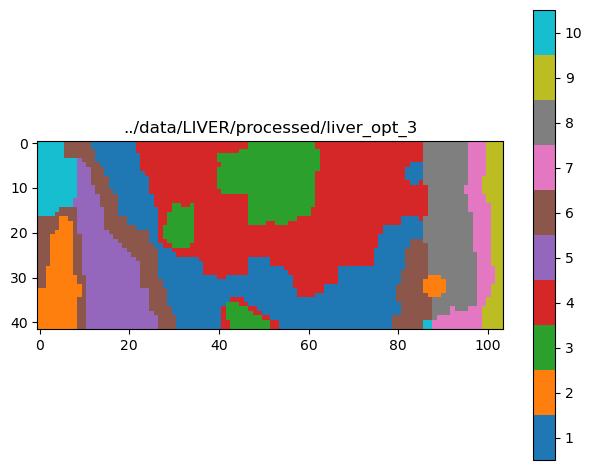

interactive(children=(SelectMultiple(description='Select Labels', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10), val…

Button(description='Save Selection', icon='save', style=ButtonStyle(), tooltip='Click to save your selection o…

Selected labels saved to ../data/LIVER/processed/liver_opt_3/segmentation.npy


In [ ]:
from scipy import ndimage

# TODO: Update each time
# Define the file to apply HCA and if to load HCA to update selection or
# train HCA
load = True
file_index = 2
file = files[file_index]

# Open selected file
with ImzMLParser(file) as p:
  # Read mass spectrometry imaging data
  mzs, img = read_msi(p)
  # Filter data for lipid range
  mzs_filter = (mzs >= MZ_LIPID_START) & (mzs <= MZ_LIPID_END)
  img_filter = img[:, :, mzs_filter]
  # Smooth the image using a Gaussian filter
  smoothed_img = ndimage.median_filter(img_filter, 5)
  #smoothed_img = img_filter
  # Flatten the image for clustering
  flat_img = smoothed_img.reshape(-1, smoothed_img.shape[-1])
  # Load or compute clustering model
  if load:
    with open(file.parent / "hca_common_representation.pkl", 'rb') as f:
      model = pickle.load(f)
  else:
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
    model.fit(flat_img)
    path = file.parent / "hca_common_representation.pkl"
    with open(path, 'wb') as f:
      pickle.dump(model, f)
  # Visualize the clusters using dendrogram
  labels = plot_dendrogram(model, truncate_mode="level", p=NUM_OF_CLUSTERS)
  # Reshape labels to match the original image dimensions
  seg = labels.reshape(smoothed_img.shape[:-1])
  # Display segmentation map with color bar
  seg_map = plt.imshow(seg, cmap='tab10', vmax=seg.max() + 1)
  cbar = plt.colorbar(seg_map)
  unique_labels = np.unique(seg)
  cbar.set_ticks(unique_labels + 0.5)
  cbar.set_ticklabels(unique_labels)
  plt.title(file.parent)
  plt.tight_layout()
  plt.show()


def save_selected_labels(selected_labels: List[int]) -> None:
  """Save the selected labels to a file. Will also save the tissue segmentation
      mask.

  Args:
    selected_labels (AgglomerativeClustering): Array of labels selected by 
        the user for saving.
      
  """
  # Save background labels
  path = file.parent / "hca_common_representation_bg_labels.npy"
  np.save(path, selected_labels)
  # Save binary mask of selected labels
  path = file.parent / "segmentation.npy"
  np.save(path, ~np.isin(seg, selected_labels))
  print(f"Selected labels saved to {path}")


@widgets.interact
def update_plot(
    selected_labels=widgets.SelectMultiple(
        options=unique_labels, description="Select Labels"
    )
) -> None:
  """Update the plot based on the selected labels from the user interface.

  Args:
    selected_labels (List[int]): Array of labels selected by the user.
      
  """
  mask = np.isin(seg, selected_labels)
  plt.imshow(mask, cmap='gray')
  plt.title(f'Selected Labels: {selected_labels}')
  plt.show()


# Button for saving selected labels
button = widgets.Button(
    description='Save Selection', button_style='',
    tooltip='Click to save your selection of labels to disk', icon='save'
)

# Display the button
display(button)


# Function to capture the current selection and save it
def on_button_clicked(b: widgets.Button):
  """Handle button click event to save selected labels.

  Args:
    b (widgets.Button): The button instance that was clicked.
      
  """
  selected_labels = update_plot.widget.kwargs['selected_labels']
  save_selected_labels(selected_labels)


# Link the button to the action function
button.on_click(on_button_clicked)

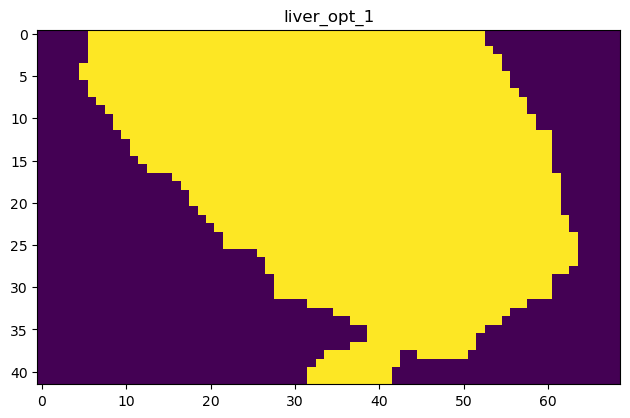

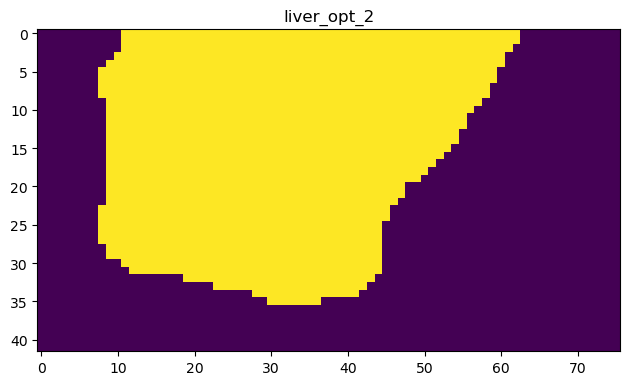

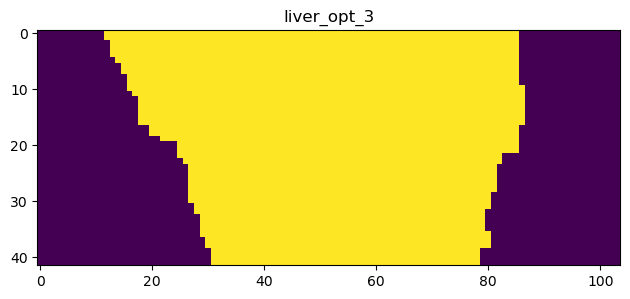

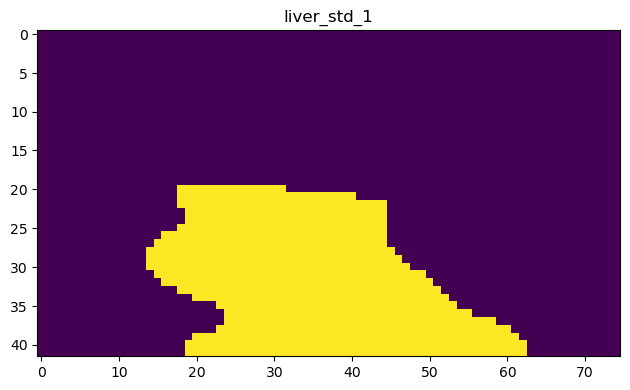

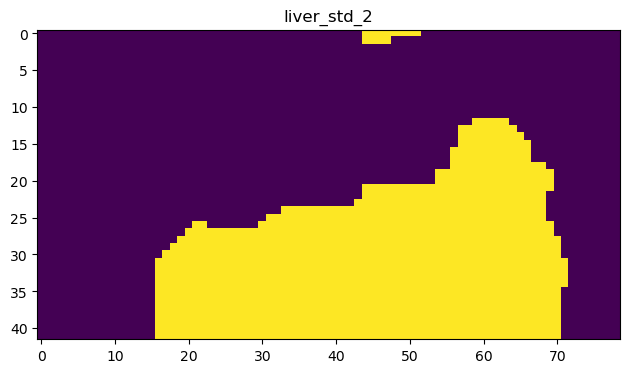

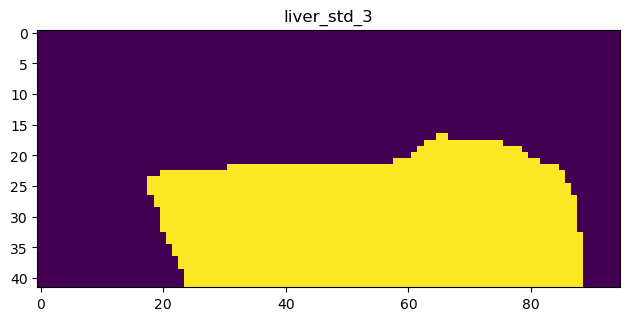

In [ ]:
for folder in PROCESSED_DATA.iterdir():
  segment_img = np.load(folder / "segmentation.npy", mmap_mode='r')
  plt.imshow(segment_img)
  plt.title(folder.name)
  plt.tight_layout()
  plt.show()


In [4]:
for folder in PROCESSED_DATA.iterdir():
  for file in folder.iterdir():
    # Parse the msi file
    if 'common_representation.imzML' == file.name:
      with ImzMLParser(file) as reader:
        # Get full msi
        mzs, img = read_msi(reader)
        # Segment image
        segment_img = np.load(file.parent / "segmentation.npy", mmap_mode='r')
        # Apply image correction
        zscore_img = ZScoreCorrection().correct(img, segment_img)

        # Open writer
        with ImzMLWriter(
            file.parent / "meaningful_signal.imzML", mode="continuous"
        ) as writer:
          # Save zscore image
          for _, (x, y, z) in enumerate(reader.coordinates):
            writer.addSpectrum(mzs, zscore_img[y - 1, x - 1], (x, y, z))

In [7]:
estimated_baseline = np.median(img[~segment_img, :], axis=0)

In [8]:
estimated_baseline.shape

(92000,)

In [13]:
(img - estimated_baseline)[0, 0, :]

array([-3.0356473e-05,  0.0000000e+00,  0.0000000e+00, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00])

In [11]:
img[0, 0, :]

array([0., 0., 0., ..., 0., 0., 0.])